# U.S. Geological Survey Intro to MODFLOW Class
San Diego, CA\
January 6-10, 2025

## Setting up and Running Prior Monte Carlo and PEST++

In [1]:
import os
import shutil
from pathlib import Path

import flopy as fp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyemu
import platform

### *quick note* - if you want to fiddle with options, you can change where you will write the results by setting the following variable

In [2]:
rundir = Path("../tmprun")

### We are going to make heavy use of python and `pyemu` (basically the `flopy` of the PEST world). There are a couple more high-level (but more abstract) ways to do this that are powerful and performant. In particular, one is `PstFrom` which is discussed in this [GMDSI Tutorial](https://github.com/gmdsi/GMDSI_notebooks/tree/main/tutorials/part2_01_pstfrom_pest_setup). Also, a new advance in parameterization is in the [`pypestutils`](https://github.com/pypest/pypestutils) package we we will touch on a bit later.

### For now, though, we will work through "the hard way" to better see what we are actually doing. #showyerwork

## So, first up we need to define a location for the background files to start with, and a setup directory to copy to and work in

In [3]:
org_d = Path("../pest_background_files/")
t_d = Path("../pest_ies_setup")

### Now we need to also get the binaries in place

In [4]:
bindir = Path('../bin/')
if 'window' in platform.platform().lower():
    shutil.copy2(bindir / 'win' / 'pestpp-ies.exe', org_d / 'pestpp-ies.exe')
elif 'macos' in platform.platform().lower():
    shutil.copy2(bindir / 'mac' / 'pestpp-ies', org_d / 'pestpp-ies')
    os.system(f'xattr -d com.apple.quarantine {str(org_d / "pestpp-ies")}')
else:
    shutil.copy2(bindir / 'linux' / 'pestpp-ies', org_d / 'pestpp-ies')

xattr: ../pest_background_files/pestpp-ies: No such xattr: com.apple.quarantine


In [5]:
if t_d.exists():
    shutil.rmtree(t_d)
shutil.copytree(org_d, t_d)

PosixPath('../pest_ies_setup')

### Let's start out with pilot points for HK in the aquifer and the clay layer

### get spatial reference for the model - pilot points are based on geographic coordinates (not on layer/row/column)

More information on pilot point parameterization at this [GMDSI Tutorial](https://github.com/gmdsi/GMDSI_notebooks/tree/main/tutorials/part1_07_pilotpoints_setup) or in this [USGS Scientific Investigations Report](https://pubs.usgs.gov/sir/2010/5168/pdf/sir20105168.pdf)
![image.png](./pp.png)

In [6]:
sim = fp.mf6.MFSimulation.load(sim_ws=str(t_d))
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package chd...
    loading package rch...
    loading package riv...
    loading package wel...
    loading package obs...
  loading solution package at...


In [7]:
sr = pyemu.helpers.SpatialReference.from_namfile(
    str(t_d / "at.nam"), delr=gwf.dis.delr.array, delc=gwf.dis.delc.array
)
sr

   could not remove start_datetime


xul:0; yul:20000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

### set up variograms for K pilot points

For more background on variograms and geostatistics, check out this [GMDSI tutorial](https://github.com/gmdsi/GMDSI_notebooks/tree/main/tutorials/part0_intro_to_geostatistics)

In [8]:
pp_aq = 3
# exponential variogram for spatially varying parameters
v_aq = pyemu.geostats.ExpVario(
    contribution=1.0,  # sill
    a=pp_aq
    * 3
    * sr.delc[
        0
    ],  # range of correlation; length units of the model. In our case 'meters'
    anisotropy=1.0,  # name says it all
    bearing=0.0,  # angle in degrees East of North corresponding to anisotropy ellipse
)

# geostatistical structure for spatially varying parameters
aq_gs = pyemu.geostats.GeoStruct(variograms=v_aq, transform="log")

<Axes: xlabel='distance', ylabel='$\\gamma$'>

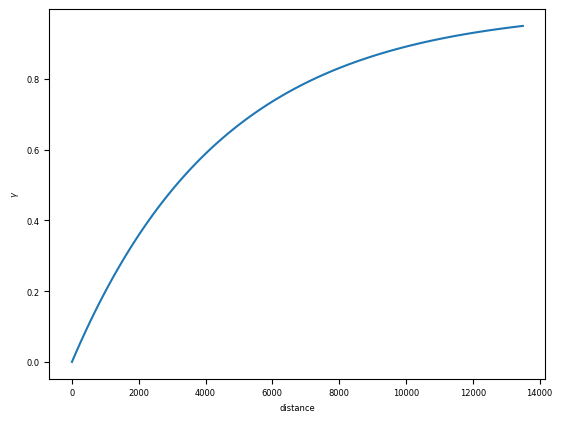

In [9]:
v_aq.plot()

In [10]:
pp_clay = 6
# exponential variogram for spatially varying parameters
v_clay = pyemu.geostats.ExpVario(
    contribution=1.0,  # sill
    a=pp_clay
    * 5
    * sr.delc[
        0
    ],  # range of correlation; length units of the model. In our case 'meters'
    anisotropy=1.0,  # name says it all
    bearing=0.0,  # angle in degrees East of North corresponding to anisotropy ellipse
)

# geostatistical structure for spatially varying parameters
clay_gs = pyemu.geostats.GeoStruct(variograms=v_clay, transform="log")

<Axes: xlabel='distance', ylabel='$\\gamma$'>

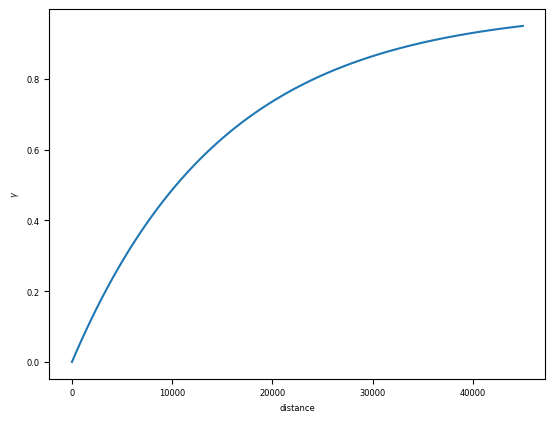

In [11]:
v_clay.plot()

In [12]:
ib = gwf.dis.idomain.array[0]

### we only need pilot points for two unique K files - k_aq and k_clay

In [13]:
k_aq = np.loadtxt(t_d / "k_aq.ref")
k_clay = np.loadtxt(t_d / "k_clay.ref")

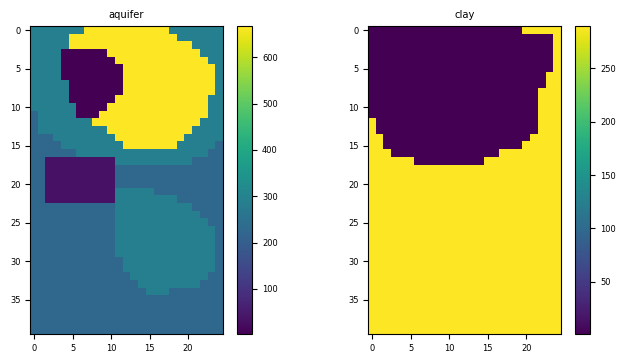

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
c = ax[0].imshow(k_aq)
plt.colorbar(c, ax=ax[0])
ax[0].set_title("aquifer")
c1 = ax[1].imshow(k_clay)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title("clay");

### we can define spatial zones based on the initial K values, assuming they are grouped as homogeneous and unique values

In [15]:
uniq_aq = np.unique(k_aq)
aq_zones_dict = dict(zip(np.arange(1, len(uniq_aq) + 1), uniq_aq))
aq_zones_dict

{1: 2.0876697546,
 2: 34.962617819,
 3: 225.52388062,
 4: 289.48642696,
 5: 666.73361113}

In [16]:
uniq_clay = np.unique(k_clay)
clay_zones_dict = dict(zip(np.arange(1, len(uniq_clay) + 1), uniq_clay))
clay_zones_dict

{1: 0.76160437974, 2: 289.48642696}

### make integer arrays of zones for the unique values of the aquifer ... 

In [17]:
aq_zones = np.zeros_like(k_aq)
for ck, cv in aq_zones_dict.items():
    aq_zones[k_aq == cv] = ck

### ... and the clay

In [18]:
# only put pilot points in the clay where the clay is actually present
clay_zones = np.zeros_like(k_aq)
clay_zones[k_clay == clay_zones_dict[1]] = 1

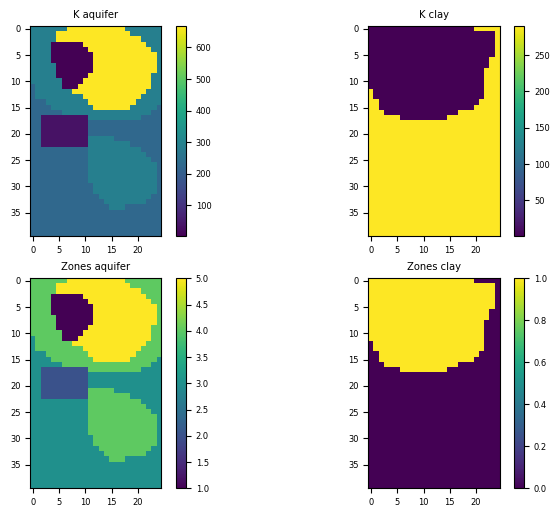

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.ravel()
c = ax[0].imshow(k_aq)
plt.colorbar(c, ax=ax[0])
ax[0].set_title("K aquifer")
c1 = ax[1].imshow(k_clay)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title("K clay")

c2 = ax[2].imshow(aq_zones)
plt.colorbar(c2, ax=ax[2])
ax[2].set_title("Zones aquifer")

c3 = ax[3].imshow(clay_zones)
plt.colorbar(c3, ax=ax[3])
ax[3].set_title("Zones clay");

## let's set up pilot points for the k files 

In [20]:
aq_pp_df = pyemu.pp_utils.setup_pilotpoints_grid(
    sr=sr,  # model spatial reference
    ibound=aq_zones,  # to which cells to setup ppoints
    # ibound=np.ones_like(aq_zones),
    prefix_dict={0: ["hk_aq"]},  # prefix to add to parameter names
    pp_dir=t_d,
    tpl_dir=t_d,
    shapename=str(t_d / "pp_aq.shp"),
    use_ibound_zones=True,
    every_n_cell=pp_aq,
)  # pilot point spacing

(0.0, 12500.0)

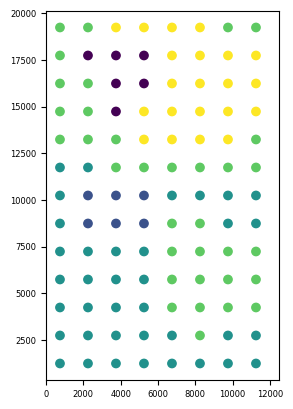

In [21]:
plt.scatter(x=aq_pp_df.x, y=aq_pp_df.y, c=aq_pp_df.zone)
plt.axis("square")
plt.xlim([0, 12500])

In [22]:
clay_pp_df = pyemu.pp_utils.setup_pilotpoints_grid(
    sr=sr,  # model spatial reference
    ibound=clay_zones,  # to which cells to setup ppoints
    prefix_dict={0: ["hk_clay"]},  # prefix to add to parameter names
    pp_dir=t_d,
    tpl_dir=t_d,
    shapename=str(t_d / "pp_clay.shp"),
    use_ibound_zones=True,
    every_n_cell=pp_clay,
)  # pilot point spacing

(0.0, 12500.0)

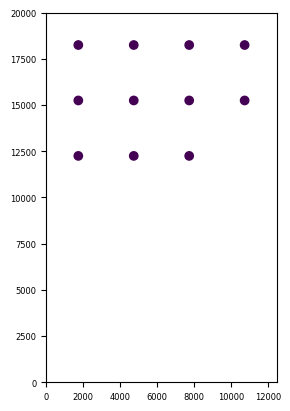

In [23]:
plt.scatter(x=clay_pp_df.x, y=clay_pp_df.y, c=clay_pp_df.zone)
plt.axis("square")
plt.ylim([0, 20000])
plt.xlim([0, 12500])

### Now we make an `OrdinaryKrige` object for each pilot point network. This holds the information needed for setting up interpolation, and also has methods to perform the interpolation.

In [24]:
ok_aq = pyemu.geostats.OrdinaryKrige(
    aq_gs, aq_pp_df.loc[aq_pp_df.pargp == "hk_aq"]
)
ok_clay = pyemu.geostats.OrdinaryKrige(
    clay_gs, clay_pp_df.loc[clay_pp_df.pargp == "hk_clay"]
)

### We need factors for the interpolation here. Basically a set of weights for each grid cell, based on distance from the nearest pilot points, from which a weighted average of pilot point values is used to calculate the value in each cell. The function of weight by distance is informed by the variogram above. 

In [25]:
aq_fac_df = ok_aq.calc_factors_grid(
    sr,
    minpts_interp=1,
    maxpts_interp=10,
)
clay_fac_df = ok_clay.calc_factors_grid(
    sr,
    minpts_interp=1,
    maxpts_interp=10,
)

starting interp point loop for 1000 points
took 0.692639 seconds
starting interp point loop for 1000 points
took 0.736067 seconds


In [26]:
# just gotta save these factors out to a file
ok_aq.to_grid_factors_file(str(t_d / "pp_aq.fac"))
ok_clay.to_grid_factors_file(str(t_d / "pp_clay.fac"))

In [27]:
list(t_d.glob("*.fac"))

[PosixPath('../pest_ies_setup/pp_clay.fac'),
 PosixPath('../pest_ies_setup/pp_aq.fac')]

In [28]:
# let's check out all the useful information we have in factors dataframe
aq_fac_df

,x,y,idist,inames,ifacts,err_var
0,250.0,19750.0,"[707.1067811865476, 2061.5528128088304, 2061.5528128088304, 3535.5339059327375, 3535.53390593273...","[pp_0000, pp_0001, pp_0008, pp_0002, pp_0016, pp_0018, pp_0003]","[0.7736179117782175, 0.05089159447134091, 0.05037739169795752, 0.02155424462216176, 0.0448270508...",0.133189
1,750.0,19750.0,"[500.0, 1581.1388300841897, 3041.38126514911, 3500.0, 4527.6925690687085, 4609.772228646444]","[pp_0000, pp_0001, pp_0002, pp_0016, pp_0003, pp_0018]","[0.7843888886459814, 0.13541864223493308, 0.02318743266002807, 0.01831260443412193, 0.0279338127...",0.107867
2,1250.0,19750.0,"[707.1067811865476, 1118.033988749895, 2549.5097567963926, 3535.5339059327375, 4031.128874149275...","[pp_0000, pp_0001, pp_0002, pp_0016, pp_0003, pp_0018]","[0.6011194011821877, 0.33078768259614405, 0.03065277716852215, 0.005782102319957127, 0.025250820...",0.148857
3,1750.0,19750.0,"[707.1067811865476, 1118.033988749895, 2061.5528128088304, 3535.5339059327375, 3640.054944640259...","[pp_0001, pp_0000, pp_0002, pp_0003, pp_0016, pp_0018]","[0.5600859642844322, 0.35025856030235564, 0.05402016804187807, 0.02695502845743709, 0.0039420316...",0.154230
4,2250.0,19750.0,"[500.0, 1581.1388300841897, 1581.1388300841897, 3041.38126514911, 3500.0, 3807.886552931954]","[pp_0001, pp_0000, pp_0002, pp_0003, pp_0017, pp_0018]","[0.6770413164906338, 0.15025792389373333, 0.13286255283924858, 0.032148952809166645, 0.003163240...",0.127366
...,...,...,...,...,...,...
995,10250.0,250.0,"[1118.033988749895, 1414.213562373095, 2236.06797749979, 3640.0549446402592, 4031.128874149275, ...","[pp_0102, pp_0103, pp_0101, pp_0100, pp_0086, pp_0087, pp_0092]","[0.43970862281869355, 0.36619504938290687, 0.10859184829498857, 0.05739905229012797, 0.006931027...",0.200424
996,10750.0,250.0,"[1118.033988749895, 1414.213562373095, 2692.582403567252, 4031.128874149275, 4123.105625617661, ...","[pp_0103, pp_0102, pp_0101, pp_0087, pp_0100, pp_0086, pp_0085]","[0.5243873674289161, 0.31486280305451214, 0.06899838438360371, 0.021714392461016616, 0.053493192...",0.194072
997,11250.0,250.0,"[1000.0, 1802.7756377319947, 3162.2776601683795, 4000.0, 4272.001872658766, 4609.772228646444, 5...","[pp_0103, pp_0102, pp_0101, pp_0087, pp_0086, pp_0100, pp_0085]","[0.6475592262793268, 0.1925534368544475, 0.05008431603937684, 0.03364689968778511, 0.00043367930...",0.181107
998,11750.0,250.0,"[1118.033988749895, 2236.06797749979, 2549.5097567963926, 3640.0549446402592, 4031.128874149275,...","[pp_0103, pp_0102, pp_0095, pp_0101, pp_0087, pp_0100, pp_0085]","[0.6822250583264885, 0.10994162681244529, 0.023471091602661167, 0.04066141482321463, 0.053619358...",0.190696


# now make a PST file to pull this all together
### recall the general structure of the PST interface

In [29]:
from IPython.display import Image, display

display(Image(url="../background/pest_flow1.gif"))

### so, let's have a look at the interface files (`tpl` and `ins`)

In [30]:
list(t_d.glob("*.tpl"))

[PosixPath('../pest_ies_setup/hk_aqpp.dat.tpl'),
 PosixPath('../pest_ies_setup/at.rch.tpl'),
 PosixPath('../pest_ies_setup/riv.ref.tpl'),
 PosixPath('../pest_ies_setup/hk_claypp.dat.tpl'),
 PosixPath('../pest_ies_setup/at.npf.tpl')]

### So we have two `pp` related `tpl` files, and some homebrewed other ones made ahead of time. Let's check those out as well.

In [31]:
# here's the river file - looks like we gonna
# parameterize conductance as homog (is that cool???)
[print(i.strip()) for i in open(t_d / "riv.ref.tpl", "r").readlines()];

ptf #
1        23         9 1.750E+00 #rv1     # -2.000E+0 pf
1        24         9 1.650E+00 #rv1     # -2.000E+0 pf
1        25         9 1.550E+00 #rv1     # -2.000E+0 ds
1        26         9 1.450E+00 #rv1     # -2.000E+0 ds
1        27         9 1.350E+00 #rv1     # -2.000E+0 ds
1        28         9 1.250E+00 #rv1     # -2.000E+0 ds
1        29         9 1.150E+00 #rv1     # -2.000E+0 ds
1        30         9 1.050E+00 #rv1     # -2.000E+0 ds
1        31         9 9.500E-01 #rv1     # -2.000E+0 ds
1        32         9 8.500E-01 #rv1     # -2.000E+0 ds
1        33         9 7.500E-01 #rv1     # -2.000E+0 ds
1        34         9 6.500E-01 #rv1     # -2.000E+0 ds
1        35         9 5.500E-01 #rv1     # -2.000E+0 ds
1        36         9 4.500E-01 #rv1     # -2.000E+0 ds
1        37         9 3.500E-01 #rv1     # -2.000E+0 ds
1        38         9 2.500E-01 #rv1     # -2.000E+0 ds
1        39         9 1.500E-01 #rv1     # -2.000E+0 ds
1        40         9 5.000E-02 #rv1     #

In [32]:
# rch is easy - just a constant value
[print(i.strip()) for i in open(t_d / "at.rch.tpl", "r").readlines()];

ptf ~
BEGIN OPTIONS
SAVE_FLOWS
READASARRAYS
END OPTIONS

BEGIN PERIOD 1
RECHARGE
CONSTANT ~   rch         ~
END PERIOD


In [33]:
# npf has some shenanigans going on
[print(i.strip()) for i in open(t_d / "at.npf.tpl", "r").readlines()];

ptf ~
BEGIN OPTIONS
SAVE_FLOWS
END OPTIONS

BEGIN GRIDDATA
ICELLTYPE LAYERED
CONSTANT 1
CONSTANT 0
CONSTANT 0
CONSTANT 0
CONSTANT 0
K LAYERED
OPEN/CLOSE k_aq.ref
OPEN/CLOSE k_aq.ref
OPEN/CLOSE k_clay.ref IPRN 5
OPEN/CLOSE k_aq.ref
OPEN/CLOSE k_aq.ref
K33 LAYERED
OPEN/CLOSE k_aq.ref FACTOR ~   Kaniso    ~
OPEN/CLOSE k_aq.ref FACTOR ~   Kaniso    ~
OPEN/CLOSE k_clay.ref FACTOR ~ Kaniso_clay ~
OPEN/CLOSE k_aq.ref FACTOR ~   Kaniso    ~
OPEN/CLOSE k_aq.ref FACTOR ~   Kaniso    ~
END GRIDDATA


#### for `npf`, we have just the two files we assume are being made my the pilot point interpolation - `k_aq.ref` for the aquifer and `k_clay.ref` for the clay. These two files get assigned across the 5 layers based on lithology. Not a bad idea! Then the `FACTOR` capability is used to assign a fraction to anisotropy for `k33` (queue Alden's dance). 

#### how about `ins` files?

In [34]:
list(t_d.glob("*.ins"))

[PosixPath('../pest_ies_setup/allobs.dat.ins')]

In [35]:
# just the one we made in the previous notebook
[print(i.strip()) for i in open(t_d / "allobs.dat.ins", "r").readlines()];

pif ~
l2 w !w01!
l1 w !w02!
l1 w !w03!
l1 w !w04!
l1 w !w05!
l1 w !w06!
l1 w !w07!
l1 w !w08!
l1 w !w09!
l1 w !w10!
l1 w !w11!
l1 w !w12!
l1 w !w13!
l1 w !w14!
l1 w !w15!
l1 w !w16!
l1 w !w17!
l1 w !u01!
l1 w !u02!
l1 w !u03!
l1 w !u04!
l1 w !u05!
l1 w !u06!
l1 w !u07!
l1 w !u08!
l1 w !u09!
l1 w !u10!
l1 w !u11!
l1 w !u12!
l1 w !u13!
l1 w !u14!
l1 w !u15!
l1 w !u16!
l1 w !u17!
l1 w !chdflow!
l1 w !pf!
l1 w !ds!
l1 w !uw02!
l1 w !uw08!
l1 w !uw15!


#### OK! Given all this info, the method below (`Pst.from_io_files`) reads all the `tpl` and `ins` files in a directory, scrapes the parameter and observation information from them, and populated a `Pst` object in memory that contains defaults and specifics covering basically everything the PEST interface will, ultimately, need.

In [36]:
cwd = Path(os.getcwd())
os.chdir(t_d)
pst = pyemu.Pst.from_io_files(*pyemu.helpers.parse_dir_for_io_files("."))
os.chdir(cwd)

### Both the `parameter_data` and `observation_data` are populated as `pandas DataFrames` (i know, easier if `recarrays` but....) so you can view and change values easily

In [37]:
pars = pst.parameter_data
pars

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,j,zone
hk_aq_i:10_j:10_zone:5,hk_aq_i:10_j:10_zone:5,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,10,10,5
hk_aq_i:10_j:13_zone:5,hk_aq_i:10_j:13_zone:5,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,10,13,5
hk_aq_i:10_j:16_zone:5,hk_aq_i:10_j:16_zone:5,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,10,16,5
hk_aq_i:10_j:19_zone:5,hk_aq_i:10_j:19_zone:5,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,10,19,5
hk_aq_i:10_j:1_zone:4,hk_aq_i:10_j:1_zone:4,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,10,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
hk_clay_i:9_j:9_zone:1,hk_clay_i:9_j:9_zone:1,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,9,9,1
kaniso,kaniso,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN,NaN,NaN
kaniso_clay,kaniso_clay,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN,NaN,NaN
rch,rch,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN,NaN,NaN


### We need to set meaningful starting values

### first set constant parameter values

In [38]:
pars.loc[pars.parnme.str.contains("aniso")]

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,j,zone
kaniso,kaniso,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN,NaN,NaN
kaniso_clay,kaniso_clay,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN,NaN,NaN


In [39]:
pars.loc["rv1", "parval1"] = 1e05  # starting value
pars.loc["rv1", "parlbnd"] = 1e03  # lower bound
pars.loc["rv1", "parubnd"] = 1e06  # upper bound
pars.loc["rv1", "pargp"] = "riv_cond"  # group (same for those below)

pars.loc["rch", "parval1"] = 0.003641
pars.loc["rch", "parlbnd"] = 0.003641 * 0.9
pars.loc["rch", "parubnd"] = 0.003641 * 1.1
pars.loc["rch", "pargp"] = "rch"

pars.loc["kaniso", "parval1"] = 0.2
pars.loc["kaniso", "parlbnd"] = 0.001
pars.loc["kaniso", "parubnd"] = 0.85
pars.loc["kaniso", "pargp"] = "anisotropy"

pars.loc["kaniso_clay", "parval1"] = 0.5
pars.loc["kaniso_clay", "parlbnd"] = 0.001
pars.loc["kaniso_clay", "parubnd"] = 0.85
pars.loc["kaniso_clay", "pargp"] = "anisotropy_clay"

### next let's use the "zone" information from the pilot points to assign groups by array _and_ zone

In [40]:
pars.loc[~pars.zone.isnull(), "pargp"] = [
    f"{i.split('_i:')[0]}_{int(float(z))}"
    for i, z in zip(
        pars.loc[~pars.zone.isnull()].parnme,
        pars.loc[~pars.zone.isnull()].zone,
    )
]

In [41]:
pars.zone = [float(i) for i in pars.zone]
pars.sample(5)

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,j,zone
hk_aq_i:28_j:7_zone:3,hk_aq_i:28_j:7_zone:3,log,factor,1.0,1.100000e-10,1.100000e+10,hk_aq_3,1.0,0.0,1,28,7,3.0
hk_aq_i:22_j:10_zone:2,hk_aq_i:22_j:10_zone:2,log,factor,1.0,1.100000e-10,1.100000e+10,hk_aq_2,1.0,0.0,1,22,10,2.0
hk_aq_i:1_j:16_zone:5,hk_aq_i:1_j:16_zone:5,log,factor,1.0,1.100000e-10,1.100000e+10,hk_aq_5,1.0,0.0,1,1,16,5.0
hk_aq_i:22_j:7_zone:2,hk_aq_i:22_j:7_zone:2,log,factor,1.0,1.100000e-10,1.100000e+10,hk_aq_2,1.0,0.0,1,22,7,2.0
hk_aq_i:1_j:13_zone:5,hk_aq_i:1_j:13_zone:5,log,factor,1.0,1.100000e-10,1.100000e+10,hk_aq_5,1.0,0.0,1,1,13,5.0


### Without enforcing too much structure, we can adjust a few starting values and bounds to inform ies of at least some of the general patterns of K values

In [42]:
pars.loc[pars.pargp.str.contains("hk_aq"), "parval1"] = 200
pars.loc[pars.pargp.str.contains("hk_aq"), "parlbnd"] = 0.01
pars.loc[pars.pargp.str.contains("hk_aq"), "parubnd"] = 1e3
pars.loc[pars.pargp.str.contains("hk_clay"), "parval1"] = 1
pars.loc[pars.pargp.str.contains("hk_clay"), "parlbnd"] = 0.0001
pars.loc[pars.pargp.str.contains("hk_clay"), "parubnd"] = 1e2
pars.loc[pars.pargp == "hk_aq_5", "parval1"] = 200
pars.loc[pars.pargp == "hk_aq_4", "parval1"] = 200
pars.loc[pars.pargp == "hk_aq_3", "parval1"] = 200
pars.loc[pars.pargp == "hk_aq_4", "parubnd"] = 750
pars.loc[pars.pargp == "hk_aq_3", "parubnd"] = 500
pars.loc[pars.pargp == "hk_clay_1", "parval1"] = 1
pars.loc[pars.pargp == "hk_clay_2", "parval1"] = 150
pars.loc[pars.pargp == "hk_clay_2", "parlbnd"] = 1
pars.loc[pars.pargp == "hk_clay_2", "parubnd"] = 1000

## next we need to read in the observation values (the known values that is) and set them

In [43]:
obsvals = pd.read_csv(t_d / "obsvalues.dat", sep=r"\s+", index_col=0)
obsvals.sample(5)

,obsval,weight,obgnme
obsnme,,,
u03,12.15,1.000000,headgroup
w03,11.83,1.000000,headgroup
u09,8.86,1.000000,headgroup
pf,-96402.00,0.000104,rivgroup
w07,9.13,1.000000,headgroup


In [44]:
pst.observation_data.sample(5)

,obsnme,obsval,weight,obgnme
w15,w15,6.837839,1.0,obgnme
u01,u01,15.737069,1.0,obgnme
w01,w01,15.704923,1.0,obgnme
w14,w14,3.303968,1.0,obgnme
u17,u17,10.279639,1.0,obgnme


In [45]:
pst.observation_data["standard_deviation"] = -99999

In [46]:
pst.observation_data.loc[obsvals.index, "obgnme"] = obsvals.obgnme
pst.observation_data.loc[obsvals.index, "obsval"] = obsvals.obsval
pst.observation_data.loc[obsvals.index, "weight"] = obsvals.weight

pst.observation_data

,obsnme,obsval,weight,obgnme,standard_deviation
chdflow,chdflow,33390.41096,0.000299,lakegroup,-99999
ds,ds,-894494.00000,0.000013,rivgroup,-99999
pf,pf,-96402.00000,0.000104,rivgroup,-99999
u01,u01,12.05000,1.000000,headgroup,-99999
u02,u02,11.63000,1.000000,headgroup,-99999
u03,u03,12.15000,1.000000,headgroup,-99999
u04,u04,11.44000,1.000000,headgroup,-99999
u05,u05,10.86000,1.000000,headgroup,-99999
u06,u06,10.80000,1.000000,headgroup,-99999
u07,u07,9.16000,1.000000,headgroup,-99999


### we need to set standard deviation values for the observations to account for their uncertainty. This uncertainty stems from multiple sources including measurement error, the process of assigning a single value to represent more than an infinitesimal snapshot in space and time, model imperfections, etc. etc. It may seem like we don't know anything!

In [47]:
# for heads, let's go with 0.25 m
pst.observation_data.loc[
    obsvals.obgnme == "headgroup", "standard_deviation"
] = 0.25
# for head differences, this can be lower as the values are quite a bit lower as well
pst.observation_data.loc[
    obsvals.obgnme == "headdiffgroup", "standard_deviation"
] = 0.025
# for the river flux and lake flux observations, we can assume 10% error around the observed values
pst.observation_data.loc[
    ~obsvals.obgnme.str.contains("head"), "standard_deviation"
] = 0.1 * np.abs(
    pst.observation_data.loc[~obsvals.obgnme.str.contains("head"), "obsval"]
)

/var/folders/gs/23hp3rd15qd6tyrfwt0r90qxz48f2r/T/ipykernel_51110/1938067274.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


In [48]:
pst.observation_data

,obsnme,obsval,weight,obgnme,standard_deviation
chdflow,chdflow,33390.41096,0.000299,lakegroup,3339.041096
ds,ds,-894494.00000,0.000013,rivgroup,89449.400000
pf,pf,-96402.00000,0.000104,rivgroup,9640.200000
u01,u01,12.05000,1.000000,headgroup,0.250000
u02,u02,11.63000,1.000000,headgroup,0.250000
u03,u03,12.15000,1.000000,headgroup,0.250000
u04,u04,11.44000,1.000000,headgroup,0.250000
u05,u05,10.86000,1.000000,headgroup,0.250000
u06,u06,10.80000,1.000000,headgroup,0.250000
u07,u07,9.16000,1.000000,headgroup,0.250000


### now we need to write out the `forward_run` script that includes pilot point interpolation, running MF6, and postprocesses the observations to prepare them for reading

#### this is hella meta - writing python using python. careful with quote marks!

In [49]:
with open(t_d / "forward_run.py", "w") as f:
    # add imports
    f.write(
        "import os\nimport shutil\nimport numpy as np\nimport pyemu\nimport flopy\n"
    )
    f.write("import pandas as pd\n")
    # preprocess pilot points to grid
    f.write(
        "_ = pyemu.geostats.fac2real('hk_aqpp.dat', factors_file='pp_aq.fac',out_file='k_aq.ref')\n"
    )
    f.write(
        "_ = pyemu.geostats.fac2real('hk_claypp.dat', factors_file='pp_clay.fac',out_file='k_clay.ref')\n"
    )
    # run MF6
    f.write("pyemu.os_utils.run('mf6')\n")
    # process the observations
    # remember to sort the glob results!
    outfiles = [
        f"./{i.name}"
        for i in sorted(list(Path("../pest_obs_prototype").glob("*.csv")))
    ]
    f.write(f"outfiles = {outfiles}\n")
    f.write("obs = pd.concat([pd.read_csv(i).T.iloc[1:] for i in outfiles])\n")
    f.write(
        "obs.loc['DS'] = obs.loc['DS'] + obs.loc['PF']\n"
    )  # note that we have to add the two river obs
    f.write(
        "obs.loc['UW02'] = obs.loc['U02']-obs.loc['W02']\n"
    )  # head difference targets
    f.write(
        "obs.loc['UW08'] = obs.loc['U08']-obs.loc['W08']\n"
    )  # head difference targets
    f.write(
        "obs.loc['UW15'] = obs.loc['U15']-obs.loc['W15']\n"
    )  # head difference targets
    f.write("obs.columns=['obsname']\n")
    f.write('obs.to_csv("allobs.dat", sep = " ")')

In [50]:
# so how does it look?
[print(i.strip()) for i in open(t_d / "forward_run.py", "r").readlines()];

import os
import shutil
import numpy as np
import pyemu
import flopy
import pandas as pd
_ = pyemu.geostats.fac2real('hk_aqpp.dat', factors_file='pp_aq.fac',out_file='k_aq.ref')
_ = pyemu.geostats.fac2real('hk_claypp.dat', factors_file='pp_clay.fac',out_file='k_clay.ref')
pyemu.os_utils.run('mf6')
outfiles = ['./at.csv', './at.wt.csv', './chd.csv', './riv.csv']
obs = pd.concat([pd.read_csv(i).T.iloc[1:] for i in outfiles])
obs.loc['DS'] = obs.loc['DS'] + obs.loc['PF']
obs.loc['UW02'] = obs.loc['U02']-obs.loc['W02']
obs.loc['UW08'] = obs.loc['U08']-obs.loc['W08']
obs.loc['UW15'] = obs.loc['U15']-obs.loc['W15']
obs.columns=['obsname']
obs.to_csv("allobs.dat", sep = " ")


### now set a few ies-specific values and write out the file

In [51]:
pst.model_command = ["python forward_run.py"]
pst.control_data.noptmax = 0  # --> we need to run once for weight rebalancing

pst.pestpp_options["ies_num_reals"] = 100
pst.pestpp_options["par_sigma_range"] = 6
pst.pestpp_options["ies_no_noise"] = "false"
pst.write(str(t_d / "mv.ies.pst"), version=2)

noptmax:0, npar_adj:119, nnz_obs:40


### copy the run folder over to be a master for parallel runs

In [52]:
if rundir.exists():
    shutil.rmtree(rundir)
shutil.copytree(t_d, rundir)

PosixPath('../tmprun')

## now we need to balance the objective function - we can start based on the initial run

### run the model once through PEST

In [53]:
pyemu.os_utils.run("pestpp-ies mv.ies.pst", str(rundir))



             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.16
binary compiled on Dec  1 2024 at 18:51:00

started at 07/03/25 13:19:44
...processing command line: ' ./pestpp-ies mv.ies.pst'
...using serial run manager

using control file: "mv.ies.pst"
in directory: "/Users/mnfienen/Documents/GIT/modflow-sandiego-2025/exercises/tmp/PEST/tmprun"
on host: "IGSACB116LHMNFI"

processing control file mv.ies.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

noptmax = 0, resetting max_run_fail = 1
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  

  ---  'noptmax'=0, running control file parameter values and quitting  ---  
...saving control file parameter ensemble to  mv.ies.base.par.csv
...initializing prior parameter covariance matrix
...parcov loaded  from parameter bounds, using par_sigma_range 6
...running control file parameter values



### now read in the residuals and see how things look

In [54]:
pst_new = pyemu.Pst(str(rundir / "mv.ies.pst"))

<Axes: >

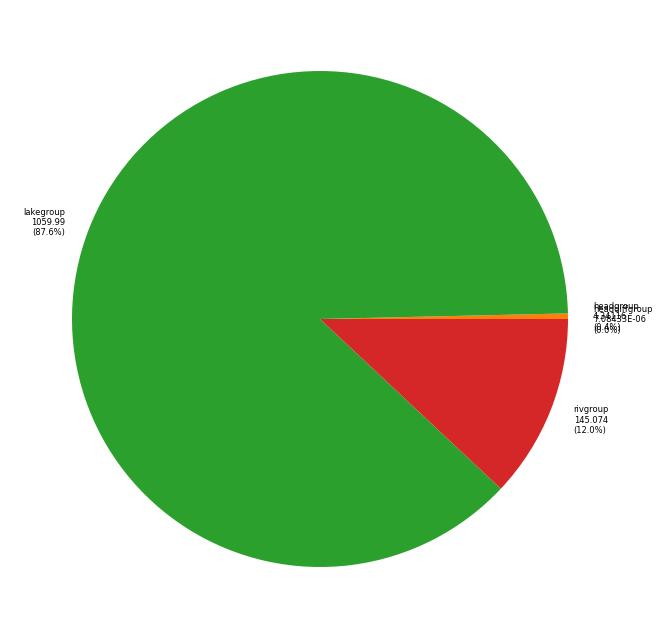

In [55]:
pst_new.plot(kind="phi_pie")

### what are the components of the objective function?

In [56]:
pst_new.phi_components

{'headdiffgroup': 7.084328174028386e-06,
 'headgroup': 4.341162000475988,
 'lakegroup': 1059.9920169070535,
 'rivgroup': 145.07415497942932}

In [57]:
phi = pst_new.phi
phi

1209.4073409712869

In [58]:
# REFERENCE BALANCE
# new_components = {
#     "headdiffgroup": phi * 0.15,
#     "headgroup": phi * 0.225,
#     "lakegroup": phi * 0.225,
#     "rivgroup": phi * 0.4,
# }

In [59]:
new_components = {
    "headdiffgroup": phi * 0.15,
    "headgroup": phi * 0.225,
    "lakegroup": phi * 0.225,
    "rivgroup": phi * 0.4,
}

In [60]:
pst_new.adjust_weights(obsgrp_dict=new_components)

In [61]:
pst_new.phi_components

{'headdiffgroup': 181.41110114569304,
 'headgroup': 272.1166517185397,
 'lakegroup': 272.1166517185395,
 'rivgroup': 483.7629363885148}

<Axes: >

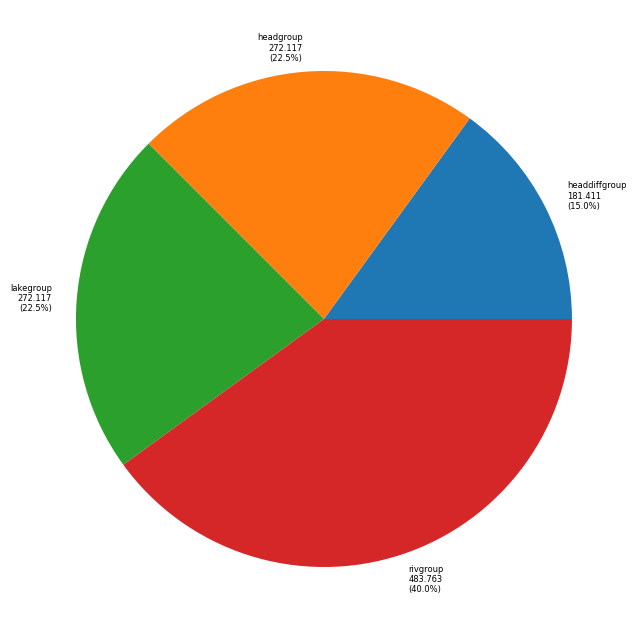

In [62]:
pst_new.plot(kind="phi_pie")

In [63]:
pst_new.observation_data

,obsnme,obsval,weight,obgnme,standard_deviation
obsnme,,,,,
chdflow,chdflow,33390.41096,0.000152,lakegroup,3339.041096
ds,ds,-894494.00000,0.000023,rivgroup,89449.400000
pf,pf,-96402.00000,0.000189,rivgroup,9640.200000
u01,u01,12.05000,7.917254,headgroup,0.250000
u02,u02,11.63000,7.917254,headgroup,0.250000
u03,u03,12.15000,7.917254,headgroup,0.250000
u04,u04,11.44000,7.917254,headgroup,0.250000
u05,u05,10.86000,7.917254,headgroup,0.250000
u06,u06,10.80000,7.917254,headgroup,0.250000


In [64]:
pst_new.control_data.noptmax = 3

In [65]:
pst_new.write(str(rundir / "mv.ies.pst"), version=2)
pst_new.write(str(t_d / "mv.ies.pst"), version=2)

noptmax:3, npar_adj:119, nnz_obs:40
noptmax:3, npar_adj:119, nnz_obs:40


### now run the parameter estimation in parallel

In [66]:
run_flag = True
if run_flag:
    pyemu.os_utils.start_workers(
        str(t_d),
        num_workers=15,
        master_dir=str(rundir),
        exe_rel_path="pestpp-ies",
        pst_rel_path="mv.ies.pst",
    )



             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.16
binary compiled on Dec  1 2024 at 18:51:00

started at 07/03/25 13:19:47
...processing command line: ' ./pestpp-ies mv.ies.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "mv.ies.pst"
in directory: "/Users/mnfienen/Documents/GIT/modflow-sandiego-2025/exercises/tmp/PEST/tmprun"
on host: "IGSACB116LHMNFI"

processing control file mv.ies.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . . ....:::::::::____  ... :
   :... `:~   